In [14]:
from pricing import BlackScholesPricer, TrinomialTree, Market, Option
from pricing.convergence import *
import datetime as dt
import sys
# limite de récursion modifée
sys.setrecursionlimit(100000)

# parametrage de l'arbre
market = Market(S0=100, r=0.05, sigma=0.30, dividend=3, dividend_date=dt.date(2026, 4, 21))
option = Option(K=102, option_type="call", maturity=dt.date(2026, 9, 1), option_class="american")
tree = TrinomialTree(market, N=700, pruning=True, epsilon=1e-10, pricing_date = dt.date(2025, 9, 1))

# prix de l'arbre
price = tree.price(option, compute_greeks=True, activate_timer=True)
print("Prix de l’option:", price)

# black Scholes
bs = BlackScholesPricer(S=market.S0, K=option.K, T=tree.delta_t * tree.N, r=market.r, sigma=market.sigma, option_type=option.option_type, dividend=market.dividend, dividend_date = market.dividend_date)
bs_price = bs.price()
print(f"Black-Scholes Price: {bs_price}")

# graphique de l'arbre
# tree.plot_tree(tree.N)


[Timer] Pricing exécuté en 0.4047 secondes.
Prix de l’option: 11.936084779553795
Black-Scholes Price: 11.593303805455307


PETITE FONCTION
ARCHITECTURE TYPE COMPTE EPARGN ETC (savoir architecturer)
PARTIE QCM

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time

def plot_runtime_vs_steps(
    market,
    option,
    N_values,
    method="backward",
    build_tree=True,
    compute_greeks=False
):
    """
    Affiche le temps d'exécution de price() en fonction du nombre de pas N (échelle log-log).
    """
    times = []
    for N in N_values:
        tree = TrinomialTree(market, N)
        start = time.perf_counter()
        tree.price(option, method="backward", build_tree=build_tree, compute_greeks=compute_greeks)
        elapsed = time.perf_counter() - start
        times.append(elapsed)

    plt.figure(figsize=(8, 5))
    plt.loglog(N_values, times, marker='o')
    plt.xlabel("Nombre de pas N (log)")
    plt.ylabel("Temps d'exécution (s, log)")
    plt.title("Temps d'exécution vs Nombre de pas (log-log)")
    plt.grid(True, which="both", ls="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

N_values = np.logspace(1, 3, 10, dtype=int)  # Par exemple N de 10 à 1000
plot_runtime_vs_steps(market, option, N_values)

# Graphique de Convergence et d'Erreur

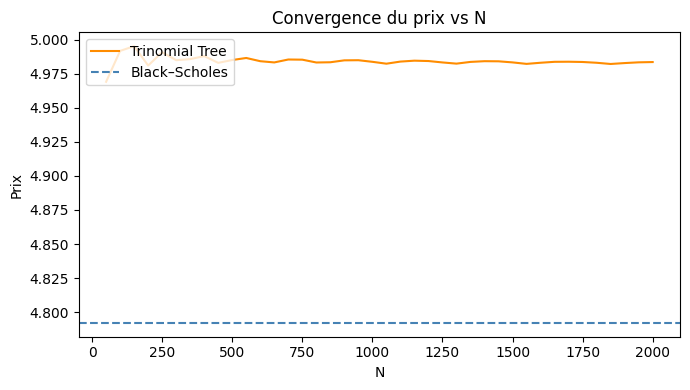

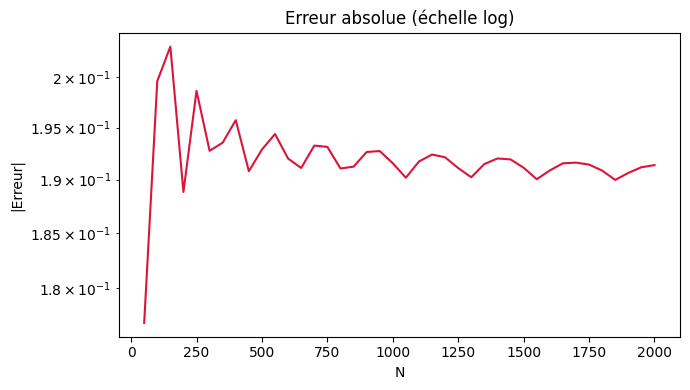

In [2]:
# bs_convergence_by_strike(market, option, strikes=range(80, 161, 3), n_steps=1000)
bs_convergence_by_step(market, option, max_n=2000, step=50, pruning=True)

# Grecques - Arbre Trinomial

In [10]:
print(f"Delta : {tree.delta():.6f}")
print(f"Gamma : {tree.gamma():.6f}")
print(f"Vega  : {tree.vega(option):.6f}")   # déjà par 1% de vol
print(f"Vanna : {tree.vanna(option):.6f}")  # déjà par 1% de vol
print(f"Rho   : {tree.rho(option):.6f}")    # déjà par 1% de taux

Delta : -0.260987
Gamma : 0.012637
Vega  : 0.299280
Vanna : -0.006493
Rho   : -0.255490


# Grecques - Black-Scholes

In [32]:
bs.greeks()

{'delta': 0.4470741981677338,
 'gamma': 0.015213088231133808,
 'theta': -0.020835951910422014,
 'vega': 0.3593539415129593,
 'rho': 0.31537557394150456,
 'vanna': 0.005026587796842479}

In [ ]:
# soutenance sur teams de 30 min
# 2 quizz jusqu'à 17h le 29/10 : un qualitatif -> questions et un quantitatif où on va 
# devoir utiliser notre code pour répondre (possible de faire un ajout de code aussi)
# exemple qualitatif : quelle est le plus gros reproche de l'abre trinomial
# le qualitatif c'est 20 questions en 20 minutes sans retour parfois choix multiples (plus qu'une réponse 
# à chaque questions à choix multiples)
# les calculs sont que des calculs faisables de test
# le qcm quantitatif n'est pas limité dans le temps (pricing d'options, du delta hedge, calcul de vega)
# toujours saisi sans retour

delta: prix_option en S0+epsilon (dans le temps) + prix_option en S0-epsilon/ 2*epsilon
c'est au QCM ça.
Les risk managers font des delta en pourcentage de la valeur du produit pour avoir des calls en % pour pouvoir comparer des produits similaires. Le epsilon est par exemple 1% de la valeur du produit. epsilon = 0.4 pour un produit à 40 et 4 pour un produit à 400 (décalage d'1%)
Il faudra utiliser la première méthode pour le QCM.

Gamma: dérivé du delta donc --> delta+ - delta- si unité de 1 de décalage
Avec un epsilon : (delta+(de epsilon) - delta-)/epsilon
à partir du prix = (Prixoption(S0 + epsilon) + Prixoption(S0-epsilon) - 2*Prixoption(S0)) / epsilon^2

Vega : (dérivé du prix par sigma) * 1%
 = (PrixS0 + 1% - PrixS0 - 1%)/2 car c'est de la vol

vega = dérivé seconde par rapport à la vol

vanna = dérivé croisée = dérivé du vega par rapport au spot = dérivée du delta par rapport à la vol


dérivée dans le code:
le callable est une fonction qui doit prendre un float en argument (valeur par rapport à laquelle on dérive)
shift = amplituyde de la variation